<a href="https://colab.research.google.com/github/kavrit/NYC-Taxi-trip-prediction/blob/main/Capstone_Project_NYC_Taxi_Trip_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [1]:
#import required packages and libraries
!pip install haversine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from haversine import haversine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#set style for graph
sns.set_style(style='darkgrid')

# Setting fontsizes,fontweight,label weight for labels,titles.
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["legend.title_fontsize"] = 15

## **Data Preparation**

### **Mounting Drive**

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/file/d/1RMrMAQ3-Al8j6s4WLnPM3FieUkZNrPRY/view?usp=sharing'
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('NYC Taxi Data.csv') 
 
df = pd.read_csv('NYC Taxi Data.csv')

### **Data Inspection**

In [4]:
#first look checking top 5 rows
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,14-03-2016 17:24,14-03-2016 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,12-06-2016 00:43,12-06-2016 00:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,19-01-2016 11:35,19-01-2016 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,06-04-2016 19:32,06-04-2016 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,26-03-2016 13:30,26-03-2016 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1048570,id0002921,1,06-04-2016 14:16,06-04-2016 14:20,1,-73.973015,40.760948,-73.976387,40.755604,N,207
1048571,id1329189,2,24-03-2016 01:26,24-03-2016 01:38,1,-73.985550,40.727257,-73.957039,40.712387,N,740
1048572,id0408460,1,23-02-2016 16:38,23-02-2016 16:48,1,-73.972038,40.750202,-73.998360,40.733360,N,605
1048573,id0147762,1,24-05-2016 07:20,24-05-2016 07:25,1,-73.993332,40.724342,-74.004250,40.707470,N,287
1048574,id0859354,2,15-03-2016 22:00,15-03-2016 22:19,1,-73.988060,40.759548,-74.005585,40.711521,N,1169


In [6]:
#check information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1048575 non-null  object 
 1   vendor_id           1048575 non-null  int64  
 2   pickup_datetime     1048575 non-null  object 
 3   dropoff_datetime    1048575 non-null  object 
 4   passenger_count     1048575 non-null  int64  
 5   pickup_longitude    1048575 non-null  float64
 6   pickup_latitude     1048575 non-null  float64
 7   dropoff_longitude   1048575 non-null  float64
 8   dropoff_latitude    1048575 non-null  float64
 9   store_and_fwd_flag  1048575 non-null  object 
 10  trip_duration       1048575 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 88.0+ MB


In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1048575,1048575,id2875421,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vendor_id,1048575.0,NaN,NaN,NaN,1.534503,0.498808,1.0,1.0,2.0,2.0,2.0
pickup_datetime,1048575,237127,23-04-2016 21:23,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_datetime,1048575,237442,21-01-2016 22:52,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger_count,1048575.0,NaN,NaN,NaN,1.664382,1.314261,0.0,1.0,1.0,2.0,9.0
pickup_longitude,1048575.0,NaN,NaN,NaN,-73.97342,0.042802,-78.547401,-73.991859,-73.981735,-73.967308,-61.335529
pickup_latitude,1048575.0,NaN,NaN,NaN,40.750942,0.033814,34.359695,40.737377,40.75415,40.768364,51.881084
dropoff_longitude,1048575.0,NaN,NaN,NaN,-73.973361,0.042743,-79.817978,-73.99131,-73.979729,-73.963005,-61.335529
dropoff_latitude,1048575.0,NaN,NaN,NaN,40.751834,0.03645,32.181141,40.735939,40.754551,40.76984,43.911762
store_and_fwd_flag,1048575,2,N,1042766,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#check columns names
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [9]:
#Check shape of dataset
df.shape 

(1048575, 11)

### **Data Description**

*   id - a unique identifier for each trip
*   vendor_id - a code indicating the provider associated with the trip record
*   pickup_datetime - date and time when the meter was engaged
*   dropoff_datetime - date and time when the meter was disengaged
*   passenger_count - the number of passengers in the vehicle (driver entered value)
*   pickup_longitude - the longitude where the meter was engaged
*   pickup_latitude - the latitude where the meter was engaged
*   dropoff_longitude - the longitude where the meter was disengaged
*   dropoff_latitude - the latitude where the meter was disengaged
*   store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
*   trip_duration - duration of the trip in seconds



In [10]:
#first create copy of dataset before working with so that we have original data untouched
df1 = df.copy()

### **Check columns and their unique values to understand what they contain.**

In [11]:
#check unique values for categorical columnns
categorical_columns = df1.select_dtypes(include=['object'])
for col in categorical_columns:
  print(f'Unique values in categorical columns {col} are: {categorical_columns[col].unique()[:8]}\n')

Unique values in categorical columns id are: ['id2875421' 'id2377394' 'id3858529' 'id3504673' 'id2181028' 'id0801584'
 'id1813257' 'id1324603']

Unique values in categorical columns pickup_datetime are: ['14-03-2016 17:24' '12-06-2016 00:43' '19-01-2016 11:35'
 '06-04-2016 19:32' '26-03-2016 13:30' '30-01-2016 22:01'
 '17-06-2016 22:34' '21-05-2016 07:54']

Unique values in categorical columns dropoff_datetime are: ['14-03-2016 17:32' '12-06-2016 00:54' '19-01-2016 12:10'
 '06-04-2016 19:39' '26-03-2016 13:38' '30-01-2016 22:09'
 '17-06-2016 22:40' '21-05-2016 08:20']

Unique values in categorical columns store_and_fwd_flag are: ['N' 'Y']



In [12]:
#check unique values for numerical columns
numerical_columns = df1._get_numeric_data()
for col in numerical_columns:
  print(f'Unique values in numerical columns {col} are: {numerical_columns[col].unique()[:8]}\n')

Unique values in numerical columns vendor_id are: [2 1]

Unique values in numerical columns passenger_count are: [1 6 4 2 3 5 0 7]

Unique values in numerical columns pickup_longitude are: [-73.98215485 -73.98041534 -73.97902679 -74.01004028 -73.97305298
 -73.98285675 -73.96901703 -73.96927643]

Unique values in numerical columns pickup_latitude are: [40.76793671 40.73856354 40.7639389  40.7199707  40.79320908 40.74219513
 40.7578392  40.79777908]

Unique values in numerical columns dropoff_longitude are: [-73.96463013 -73.9994812  -74.00533295 -74.01226807 -73.97292328
 -73.99208069 -73.95740509 -73.92247009]

Unique values in numerical columns dropoff_latitude are: [40.76560211 40.73115158 40.71008682 40.70671844 40.78252029 40.74918365
 40.76589584 40.76055908]

Unique values in numerical columns trip_duration are: [ 455  663 2124  429  435  443  341 1551]



In [13]:
#check count of unqiue id
len(df1['id'].unique())

1048575

In [14]:
#Convert timestamp to datetime format to fetch the other details as listed below
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [15]:
#check count of unqiue id
len(df1['id'].unique())

1048575

In [16]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
df['weekday'] = df.pickup_datetime.dt.weekday
df['month'] = df.pickup_datetime.dt.month
df['weekday_num'] = df.pickup_datetime.dt.weekday
df['pickup_hour'] = df.pickup_datetime.dt.hour

In [17]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [18]:
#Calculate distance and assign new column to the dataframe.
df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)

In [19]:
#Calculate Speed in km/h for further insights
df['speed'] = (df.distance/(df.trip_duration/3600))

In [20]:
#Check the type of each variable
df.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [21]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(df.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

In [22]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:00,2016-03-14 17:32:00,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-12-06 00:43:00,2016-12-06 00:54:00,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:00,2016-01-19 12:10:00,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-06-04 19:32:00,2016-06-04 19:39:00,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:00,2016-03-26 13:38:00,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,1,0,0,0,0,0,0,0,0


Now our dataset is complete for the further analysis before we train our model with optimal variables.

### **Handling missing values.**

In [23]:
#check null values
df1.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

As we can see there are no null values in our dataset.

In [24]:
df['id'].value_counts()

id2875421    1
id3505385    1
id1499125    1
id0691227    1
id1682481    1
            ..
id0154336    1
id2546928    1
id3154693    1
id1097988    1
id0859354    1
Name: id, Length: 1048575, dtype: int64

## **EDA**

### **Total Trip per hour**

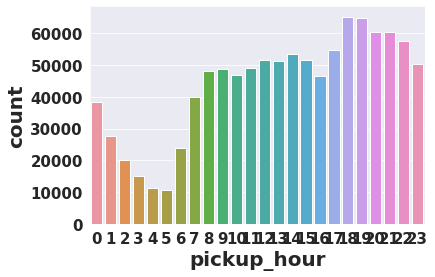

In [25]:
sns.countplot(df.pickup_hour)
plt.show()

### **Inference**

It's inline with the general trend of taxi pickups which starts increasing from 6AM in the morning and then declines from late evening i.e. around 8 PM. There is no unusual behavior here.

### **Total trips per weekday**

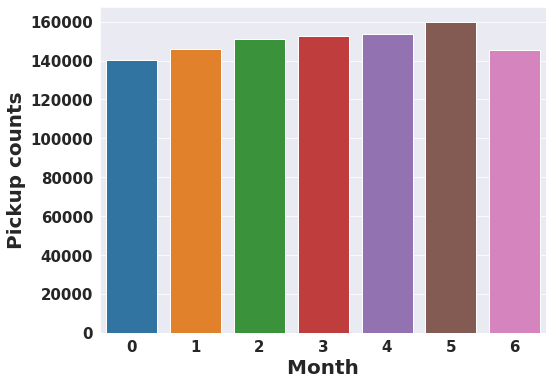

In [26]:
#Let's take a look now at the distribution of taxi pickups across the week.
plt.figure(figsize = (8,6))
sns.countplot(df.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

### **Observation**

Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends.

### **Trip Duration per hour**

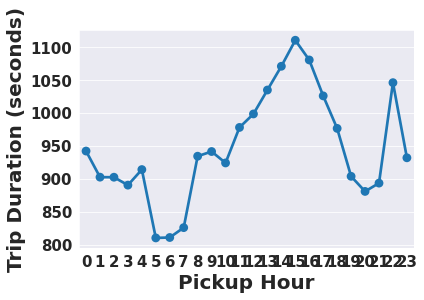

In [27]:
group1 = df.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

### **Observations**

Average trip duration is lowest at 6 AM when there is minimal traffic on the roads.

Average trip duration is generally highest around 3 PM during the busy streets

Trip duration on an average is similar during early morning hours i.e. before 6 AM & late evening hours i.e. after 6 PM.

### **Trip Duration per weekdays**

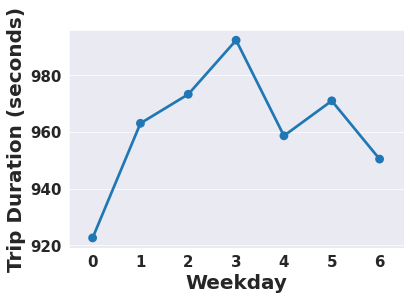

In [28]:
group2 = df.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

We can see that trip duration is almost equally distributed across the week on a scale of 0-1000 minutes with minimal difference in the duration times. Also, it is observed that trip duration on thursday is longest among all days.

### **Trip duration per month**

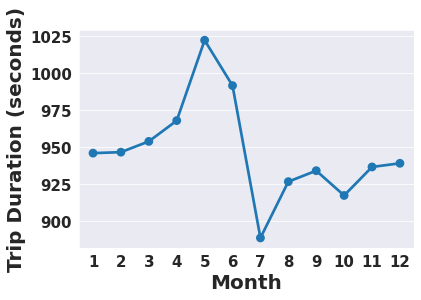

In [29]:
group3 = df.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

### **Observations**

We can see an increasing trend in the average trip duration along with each subsequent month.

The duration difference between each month is not much. It has increased gradually over a period of 6 months.

It is lowest during february when winters starts declining.

There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period. Like May is generally the considered as the wettest month in NYC and which is inline with our visualization.
 As it generally takes longer on the roads due to traffic jams during rainy season. So natually the trip duration would increase towards April May and June.

### **Trip Duration per vendor**

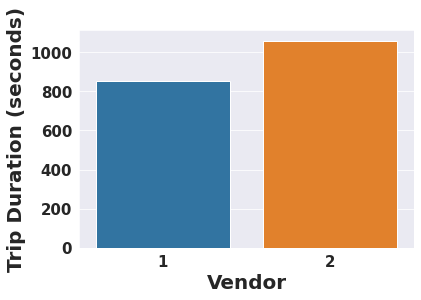

In [30]:
group4 = df.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

Vendor 2 takes the crown. Average trip duration for vendor 2 is higher than vendor 1 by approx 200 seconds i.e. atleast 3 minutes per trip.

### **Distance per Hour**

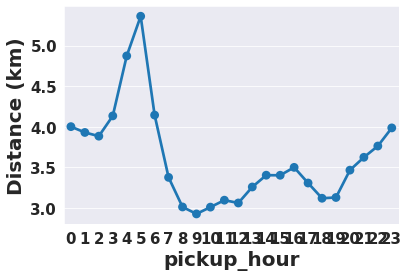

In [31]:
group5 = df.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

### **Observations**

Trip distance is highest during early morning hours which can account for some things like:
Outstation trips taken during the weekends.
Longer trips towards the city airport which is located in the outskirts of the city.

Trip distance is fairly equal from morning till the evening varying around 3 - 3.5 kms.

It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.

### **Distance per weekdays**

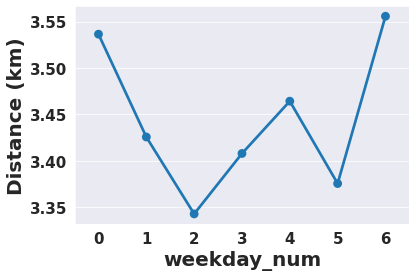

In [32]:
group6 = df.groupby('weekday_num').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

So it's a fairly equal distribution with average distance metric verying around 3.5 km/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.

### **Avarage speed per hour**

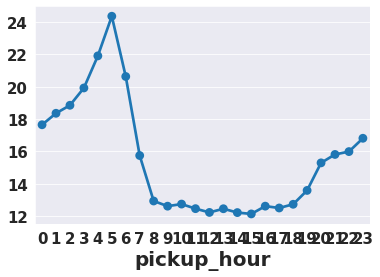

In [33]:
# Let's look at the average speed of NYC Taxi per hour
group = df.groupby('pickup_hour').speed.mean()
sns.pointplot(group.index, group.values)
plt.show()

### **Observation**


*   The average trend is totally inline with the normal circumstances.
*   Average speed tend to increase after late evening and continues to increase gradually till the late early morning hours.
*   Average taxi speed is highest at 5 AM in the morning, then it declines steeply as the office hours approaches.
*   Average taxi speed is more or less same during the office hours i.e. from 8 AM till 6PM in the evening.

### **Average speed per weekday**
Let's visualize that on an average what is the speed of a taxi on any given weekday.

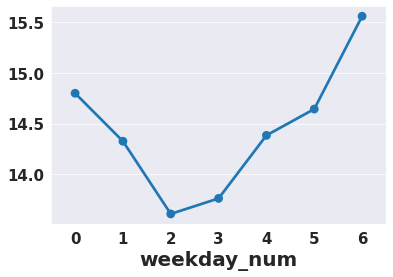

In [34]:
group10 = df.groupby('weekday_num').speed.mean()
sns.pointplot(group10.index, group10.values)
plt.show()

### **Observations**


*   Average taxi speed is higher on weekend as compared to the weekdays which is obvious when there is mostly rush of office goers and business owners.
*   Even on monday the average taxi speed is shown higher which is quite surprising when it is one of the most busiest day after the weekend. There can be several possibility for such behaviour
      1.   Lot of customers who come back from outstation in early hours of Monday before 6 AM to attend office on time.
      2.   Early morning hours customers who come from the airports after vacation to attend office/business on time for the coming week.
*   There could be some more reasons as well which only a local must be aware of.
We also can't deny the anomalies in the dataset. which is quite cumbersome to spot in such a large dataset.







# **Feature Selection**

In [35]:
#First check the index of the features and label
list(zip( range(0,len(df.columns)),df.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'weekday'),
 (12, 'month'),
 (13, 'weekday_num'),
 (14, 'pickup_hour'),
 (15, 'distance'),
 (16, 'speed'),
 (17, 'flag_Y'),
 (18, 'vendor_id_2'),
 (19, 'month_2'),
 (20, 'month_3'),
 (21, 'month_4'),
 (22, 'month_5'),
 (23, 'month_6'),
 (24, 'month_7'),
 (25, 'month_8'),
 (26, 'month_9'),
 (27, 'month_10'),
 (28, 'month_11'),
 (29, 'month_12'),
 (30, 'weekday_num_1'),
 (31, 'weekday_num_2'),
 (32, 'weekday_num_3'),
 (33, 'weekday_num_4'),
 (34, 'weekday_num_5'),
 (35, 'weekday_num_6'),
 (36, 'pickup_hour_1'),
 (37, 'pickup_hour_2'),
 (38, 'pickup_hour_3'),
 (39, 'pickup_hour_4'),
 (40, 'pickup_hour_5'),
 (41, 'pickup_hour_6'),
 (42, 'pickup_hour_7'),
 (43, 'pickup_hour_8'),
 (44, 'pickup_hour_9'),
 (45, 'pickup_hour_10'),

In [36]:
Y = df.iloc[:,10].values
X = df.iloc[:,range(15,61)].values

In [37]:
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))

Let's append 1048575 rows of 1's as the first column in the X array


In [38]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [39]:
X1.shape

(1048575, 47)

In [40]:
# X_opt = X1[:,[0,1,3,4,6,7,8,9,10,11]]
# regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()
# regressor_OLS.summary()

In [41]:
#Select all the features in X array
X_opt = X1[:,range(0,46)]
regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()

#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

#define significance level for accepting the feature.
sig_Level = 0.05

#Loop to iterate over features and remove the feature with p value less than the sig_level
while max(p_Vals) > sig_Level:
    print("Probability values of each feature \n")
    print(p_Vals)
    X_opt = np.delete(X_opt, np.argmax(p_Vals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(p_Vals))))
    print(str(X_opt.shape[1]-1) + " dimensions remaining now... \n")
    regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()
    p_Vals = regressor_OLS.pvalues
    print("====================================================================\n")
#Print final summary
print("Final stat summary with optimal {} features".format(str(X_opt.shape[1]-1)))
regressor_OLS.summary()    

Probability values of each feature 

[8.80973647e-83 0.00000000e+00 0.00000000e+00 6.27497883e-01
 1.10882845e-61 4.54343772e-01 7.80645525e-01 8.49920794e-01
 2.16697671e-02 2.32456266e-01 2.07082417e-01 6.09821555e-01
 7.93186358e-01 3.25057102e-01 5.35536806e-01 7.03850411e-01
 5.18914536e-02 6.09267316e-02 1.61468208e-02 1.38276314e-01
 8.45546223e-04 1.92087361e-02 9.46018570e-01 5.07997474e-01
 7.13702868e-01 8.34039099e-01 1.09000707e-01 6.08781452e-01
 1.07620685e-01 8.94703458e-01 9.40710803e-01 4.99705660e-01
 9.74636144e-01 6.62836022e-01 4.89131724e-01 4.86911193e-01
 1.02253309e-01 4.03865996e-01 8.06017090e-01 9.06968109e-01
 3.52504632e-01 1.76031509e-01 2.06015855e-01 2.73222534e-02
 3.27741094e-01 3.31954864e-01]


Feature at index 32 is removed 

44 dimensions remaining now... 


Probability values of each feature 

[2.83860981e-123 0.00000000e+000 0.00000000e+000 6.27451702e-001
 1.10869895e-061 4.54376209e-001 7.80657384e-001 8.49977467e-001
 2.16687104e-002 2.32432

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1861.
Date:                Wed, 24 Aug 2022   Prob (F-statistic):               0.00
Time:                        13:47:32   Log-Likelihood:            -1.0577e+07
No. Observations:             1048575   AIC:                         2.115e+07
Df Residuals:                 1048566   BIC:                         2.115e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        780.1014     10.981     71.042      0.000     758.579     801.623
x1           188.7865      1.588    118.853      0.000     185.673     191.900
x2           -40.9412      0.489    -83.708      0.000     -41.900     -39.983
x3           196.3542     11.379     17.255      0.000     174.051     218.657
x4            47.3228     16.521      2.864      0.004      14.943      79.702
x5            35.9303     15.807      2.273      0.023       4.949      66.911
x6           -61.6017     29.722     -2.073      0.038    -119.855      -3.348
x7            70.5066     26.341      2.677      0.007      18.878     122.135
x8            92.2120     24.989      3.690      0.000      43.235     141.189
================================================================================
Omnibus:                  5971683.509   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   1346703222123011.500
Skew:                         346.724   Prob(JB):                           0.00
Kurtosis:                  175568.199   Cond. No.                           110.
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **Split Data**

In [42]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

### **Feature Extraction**

In [43]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

In [44]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

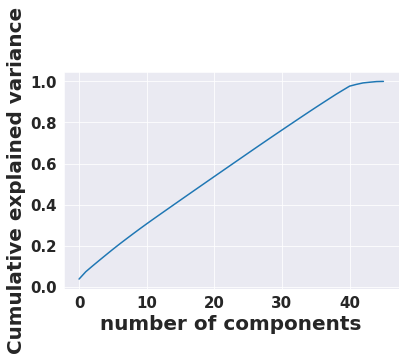

In [46]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [47]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 3.71),
 (2, 7.300000000000001),
 (3, 10.100000000000001),
 (4, 12.830000000000002),
 (5, 15.530000000000001),
 (6, 18.200000000000003),
 (7, 20.800000000000004),
 (8, 23.310000000000006),
 (9, 25.790000000000006),
 (10, 28.230000000000008),
 (11, 30.620000000000008),
 (12, 32.970000000000006),
 (13, 35.290000000000006),
 (14, 37.60000000000001),
 (15, 39.91000000000001),
 (16, 42.21000000000001),
 (17, 44.510000000000005),
 (18, 46.800000000000004),
 (19, 49.09),
 (20, 51.38),
 (21, 53.67),
 (22, 55.95),
 (23, 58.230000000000004),
 (24, 60.510000000000005),
 (25, 62.790000000000006),
 (26, 65.07000000000001),
 (27, 67.34),
 (28, 69.60000000000001),
 (29, 71.85000000000001),
 (30, 74.09),
 (31, 76.32000000000001),
 (32, 78.54),
 (33, 80.75),
 (34, 82.96),
 (35, 85.16),
 (36, 87.33),
 (37, 89.47),
 (38, 91.6),
 (39, 93.72),
 (40, 95.72),
 (41, 97.69),
 (42, 98.53999999999999),
 (43, 99.25999999999999),
 (44, 99.6),
 (45, 99.91)]

In [48]:
pca_10 = PCA(n_components=40)
X_train_pca = pca_10.fit_transform(X_train_pca)
X_test_pca = pca_10.transform(X_test_pca)

## **Heatmap**

### **On feature selection Data**

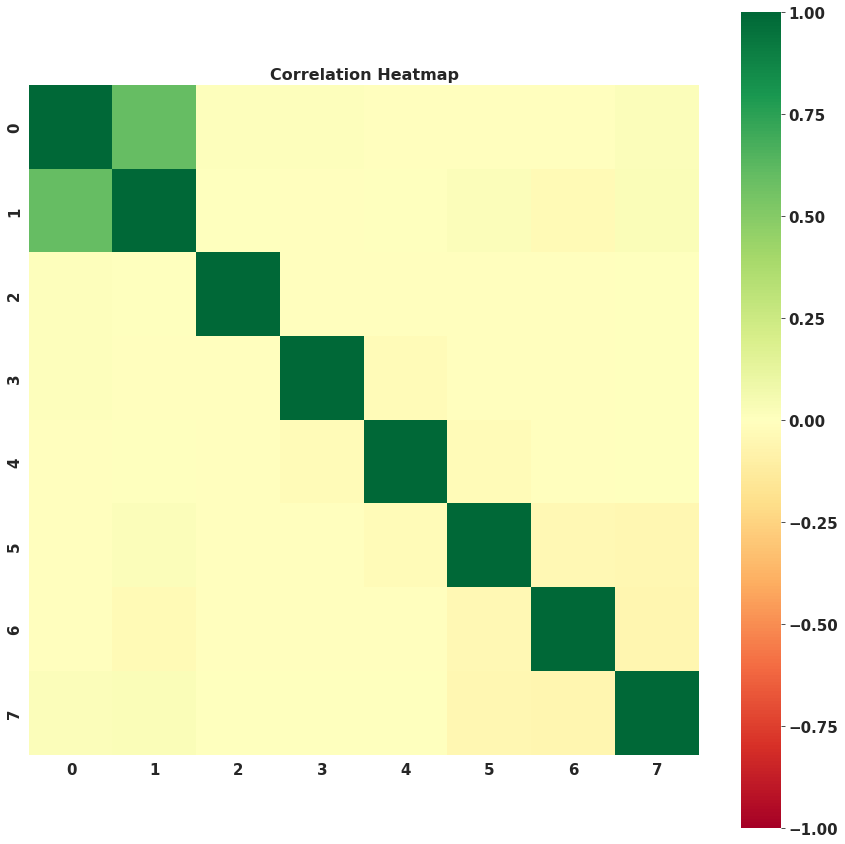

In [49]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_fs[:,1:]).corr()
corr.index = pd.DataFrame(X_train_fs[:,1:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### **Observations**

Finally we have reached the combination of optimum features with each feature having p value < 0.05.

### **On feature extraction Data**

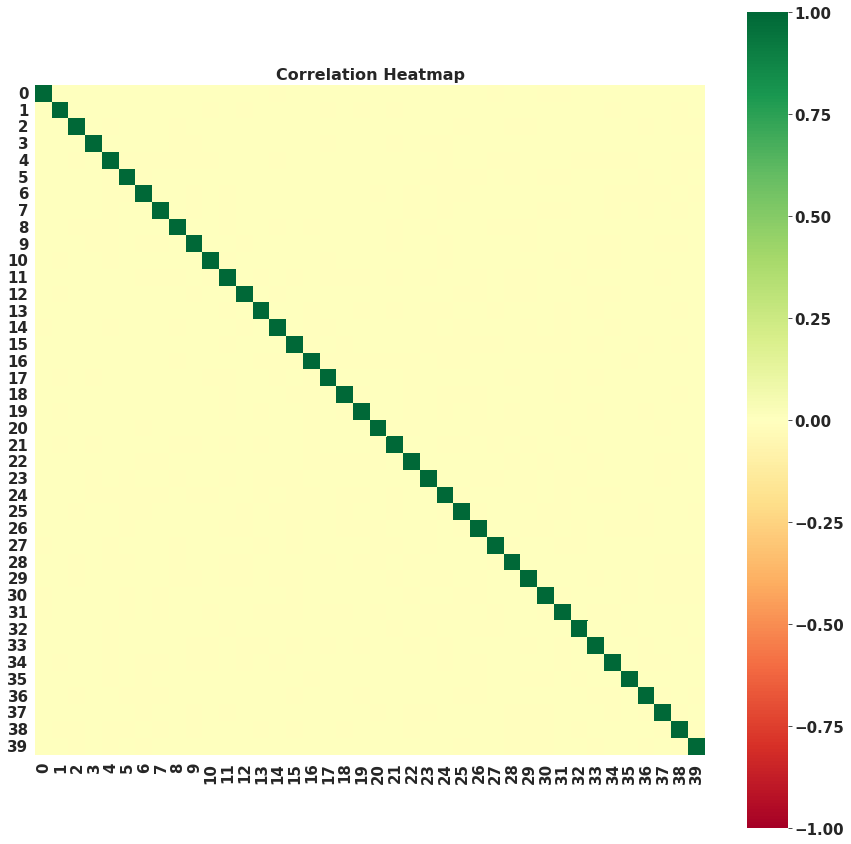

In [50]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_pca).corr()
corr.index = pd.DataFrame(X_train_pca).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### **Observations**

All of the features shows NO correlation at all. Because feature extraction removes all collinearity.

# **Linear Regression**

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

In [52]:
#Linear regressor for the raw data
regressor = LinearRegression() 
regressor.fit(X_train,y_train) 

#Linear regressor for the Feature selection group
regressor1 = LinearRegression() 
regressor1.fit(X_train_fs,y_train_fs) 

#Linear regressor for the Feature extraction group
regressor2 = LinearRegression() 
regressor2.fit(X_train_pca,y_train_pca) 

LinearRegression()

In [53]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test) 

#Predict from the test features of Feature Selection group
y_pred = regressor1.predict(X_test_fs) 

#Predict from the test features of Feature Extraction group
y_pred_pca = regressor2.predict(X_test_pca) 

In [54]:
#Evaluate the regressor on the raw data
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(X_test, y_test))
print("\n")

#Evaluate the regressor on the Feature selection group
print('RMSE score for the Multiple LR FS is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred))))
print('Variance score for the Multiple LR FS is : %.2f' % regressor1.score(X_test_fs, y_test_fs))
print("\n")

#Evaluate the regressor on the Feature extraction group
print('RMSE score for the Multiple LR PCA is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca,y_pred_pca))))
print('Variance score for the Multiple LR PCA is : %.2f' % regressor2.score(X_test_pca, y_test_pca))

RMSE score for the Multiple LR raw is : 8321.482043675796
Variance score for the Multiple LR raw is : 0.01


RMSE score for the Multiple LR FS is : 8321.482043675796
Variance score for the Multiple LR FS is : 0.01


RMSE score for the Multiple LR PCA is : 8342.934791209373
Variance score for the Multiple LR PCA is : 0.00


In [55]:
X_train.shape

(838860, 46)

In [56]:
#Find linear correlation of each feature with the target variable
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((X_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:46].columns.tolist()
target = df1.iloc[:,46].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
0 vs 46,0.095723
1 vs 46,-0.021774
3 vs 46,0.020817
44 vs 46,-0.009309
35 vs 46,0.006761
27 vs 46,-0.005487
36 vs 46,0.005104
7 vs 46,0.005057
34 vs 46,0.004934
40 vs 46,-0.004500


### **Observations**

We can see that none of the feature is linearly correlated with the target variable "46". That is why it is not a good model for the prediction of the trip duration. So let's move ahead and try the random forest regressor. We are not using decision tree regressor because the random forest will anyways consist of almost all its properties. Also, we will not use SVR because it takes too much time to train on this huge dataset even with the default settings. It seems to be not good with high dimensional dataset as well as for the huge instances.

## **Random Forest Regressor**

In [57]:
#import the packages
from sklearn.ensemble import RandomForestRegressor
# Create an instance of the RandomForestRegressor
rf_model = RandomForestRegressor()

rf_model.fit(X_train_fs,y_train_fs)

RandomForestRegressor()

In [58]:
# Making predictions on train and test data

y_pred_train_r = rf_model.predict(X_train_fs)
y_pred_test_r = rf_model.predict(X_test_fs)

### **For train data**

In [59]:
#import the packages
from sklearn.metrics import mean_squared_error
print("Model Score:",rf_model.score(X_train_fs,y_train_fs))

#calculate MSE
MSE_rf= mean_squared_error(y_train_fs, y_pred_train_r)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_train_fs, y_pred_train_r)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score(y_train_fs, y_pred_train_r)
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score(y_train_fs, y_pred_train_r))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train_fs, y_pred_train_r))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

Model Score: 0.9554216844466263
MSE : 1132390.066004882
RMSE : 1064.1381799394674
MAE : 5.064715572480479
R2 : 0.9554216844466263
Adjusted R2 : 0.9554197712598164


### **For test data**

In [60]:
#import the packages
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_rf= mean_squared_error(y_test_fs, y_pred_test_r)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_test_fs, y_pred_test_r)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score((y_test_fs), (y_pred_test_r))
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score((y_test_fs), (y_pred_test_r)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score((y_test_fs), (y_pred_test_r)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

MSE : 22262068.30172076
RMSE : 4718.269630036075
MAE : 15.644860609534268
R2 : 0.6805045632923603
Adjusted R2 : 0.6804908513687993


**Interesting find**

There is approx 200% improvement on the RMSE score for the Random forest regressor over the Linear regressor of the feature selection group.

Even the variance score is approx 1 which is a good score.

RMSE score for the RF regressor of feature extraction group is still very bad along with the variance score.

RMSE score for the feature selection group is more or less same as the raw data score. 
Sometimes the RMSE score for the raw data is better and vice versa.
It fluctuates on every iteration and this is quite weird!
Let's see if we can improve this further with the most sought after algorigthm i.e. XGBoost!!

# **XGBoost**

In [61]:
from xgboost import XGBRegressor
regressor_xgbraw = XGBRegressor(n_jobs=-1)
#instantiate the object for the XGBoost Regressor with default params for Feature Selection Group
regressor_xgb = XGBRegressor(n_jobs=-1)

In [62]:
regressor_xgb1 = XGBRegressor(n_estimators=300,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1,
                           n_jobs=-1)
#instantiate the object for the XGBoost Regressor for Feature Extraction Group
regressor_xgb2 = XGBRegressor(n_jobs=-1)

#Train the object with default params for Feature Selection Group
regressor_xgb.fit(X_train_fs,y_train_fs)

[14:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1)

In [63]:
# Making predictions on train and test data

y_pred_train_x = regressor_xgb.predict(X_train_fs)
y_pred_test_x = regressor_xgb.predict(X_test_fs)

# For Train Data

In [64]:
#import the packages
from sklearn.metrics import mean_squared_error
print("Model Score:",regressor_xgb.score(X_train_fs,y_train_fs))

#calculate MSE
MSE_rf= mean_squared_error(y_train_fs, y_pred_train_x)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_train_fs, y_pred_train_x)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score(y_train_fs, y_pred_train_x)
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score(y_train_fs, y_pred_train_x))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train_fs, y_pred_train_x))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )


Model Score: 0.9861435305372834
MSE : 351985.67228708835
RMSE : 593.2838041671864
MAE : 58.07534598862042
R2 : 0.9861435305372834
Adjusted R2 : 0.9861429358532027


# For Test Data

In [65]:
#import the packages
from sklearn.metrics import mean_squared_error
print("Model Score:",regressor_xgb.score(X_test_fs,y_test_fs))
#calculate MSE
MSE_rf= mean_squared_error(y_test_fs, y_pred_test_x)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_test_fs, y_pred_test_x)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score((y_test_fs), (y_pred_test_x))
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score((y_test_fs), (y_pred_test_x)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score((y_test_fs), (y_pred_test_x)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

Model Score: 0.8457141090184787
MSE : 10750460.408501798
RMSE : 3278.7894730375415
MAE : 65.32537852044048
R2 : 0.8457141090184787
Adjusted R2 : 0.8457074874643009




1.   As we can see here we have restricted ourselves on Feature Selection dataset only. The reason behind this is that if here the dimension increases, the time complexity also increases manyfold. So, better to check for the optimal features. Same thinking was behind the operation on Random Forest Regressr
2.   Second observation is that it works exceptionally well for both Training  and Test dataset.



## **Ridge Regression**

In [66]:
from sklearn.linear_model import Ridge

ridge1= Ridge(alpha=0.1)
ridge2= Ridge(alpha=0.1)
ridge3= Ridge(alpha=0.1)

In [67]:
#FIT THE MODEL
ridge1.fit(X_train,y_train)
# Create the model score
print(ridge1.score(X_test, y_test), ridge1.score(X_train, y_train))

0.006189150456451187 0.0191805729473028


In [68]:
# Fit the Ridge model on Feature Selection data
ridge2.fit(X_train_fs,y_train_fs)
# Create the model score
print(ridge2.score(X_test_fs,y_test_fs), ridge2.score(X_train_fs,y_train_fs))

0.006196528401387513 0.01912850032069957


In [69]:
# Fit the Ridge model on Feature Extraction data
ridge3.fit(X_train_pca,y_train_pca)
# Create the model score
print(ridge3.score(X_test_pca,y_test_pca), ridge3.score(X_train_pca,y_train_pca))

0.001065880797477936 0.00328101494060018


### **Model Prediction**
**Feature selection based**



**Train Data**

In [70]:
#get the X_train and X-test value for Feature Selection
y_pred_train_ridge_fs=ridge2.predict(X_train_fs)
y_pred_test_ridge_fs=ridge2.predict(X_test_fs)

In [71]:
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_l= mean_squared_error((y_train_fs), (y_pred_train_ridge_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_train_fs, y_pred_train_ridge_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train_fs, y_pred_train_ridge_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_train_fs, y_pred_train_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train_fs, y_pred_train_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

MSE : 24916355.148822818
RMSE : 4991.628506692262
MAE : 364.6812006163739
R2 : 0.01912850032069957
Adjusted R2 : 0.019086403835174126


**Test Data**

In [72]:
#calculate MSE
MSE_l= mean_squared_error((y_test_fs), (y_pred_test_ridge_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test_fs, y_pred_test_ridge_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train_fs, y_pred_train_ridge_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test_fs, y_pred_test_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test_fs, y_pred_test_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

MSE : 69247063.40472905
RMSE : 8321.482043766546
MAE : 378.296536367151
R2 : 0.01912850032069957
Adjusted R2 : 0.006153876908841394


### **Feature Extraction Based**

**Train Data**

In [73]:
#get the X_train and X-test value for Feature Selection
y_pred_train_ridge_pca=ridge3.predict(X_train_pca)
y_pred_test_ridge_pca=ridge3.predict(X_test_pca)

In [74]:
#calculate MSE
MSE_l= mean_squared_error((y_test), (y_pred_test_ridge_pca))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test, y_pred_test_ridge_pca)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_ridge_pca)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test, y_pred_test_ridge_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test, y_pred_test_ridge_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 69604560.92822206
RMSE : 8342.934791080537
MAE : 577.3878694056875
R2 : 0.00328101494060018
Adjusted R2 : 0.0008467201745725461





1.   For RIDGE regression, the time complexity is very less. So it enables us to explore it for optimal featues, as well as on the extended features too.
2.   However, it seems that for both dataset the result is very poor. So for this large data RIDGE regression prooves to be futile.

